In [1]:
import numpy as np
import pandas as pd
import pickle

In [3]:
with open("/home/bruce1996/nvme2/scRNA/seurat_hvgs_list.pickle",'rb') as f :
    hvgs = pickle.load(f)
f.close()

with open('/home/bruce1996/nvme2/scRNA/GSE149614_coding_gene_hepatocyte_normalized.pkl', 'rb') as f :
    exp_m = pickle.load(f)
f.close()

metadata = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/validation_dataset/scRNA/GSE149614_HCC.metadata.txt',sep='\t',index_col=0)
vote = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/ensemble_learning_result/ensemble_hbv_only_np_ratio_35_vote_result.txt",sep='\t',index_col=0)
voted_gene = list(set(vote.index[vote['Vote'] > 0]).intersection(exp_m.index))

### Exam HVG / voted gene mean & variance

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
mean = exp_m.mean(axis=1)
variance = exp_m.var(axis=1)
df = pd.concat([pd.DataFrame({'Mean' : mean[hvgs],'Variance' : variance[hvgs],'Label' : ['HVG'] * len(hvgs)}),
                pd.DataFrame({'Mean' : mean[voted_gene],'Variance' : variance[voted_gene],'Label' : ['Voted gene'] * len(voted_gene)})])

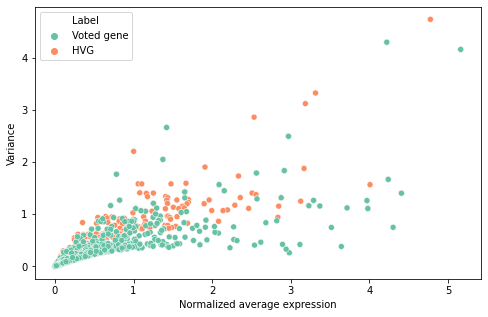

In [4]:
plt.figure(figsize=(8,5))
sns.scatterplot(data = df,x='Mean',y='Variance',hue='Label',palette='Set2',hue_order=['Voted gene','HVG'])
plt.xlabel("Normalized average expression")
plt.savefig("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/scRNA_seurat/mean_variance_scatter_plot.png",dpi=300)

### Seurat HVGs UMAP clustering

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from umap import UMAP
from matplotlib_venn import venn2

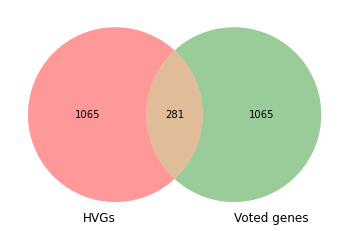

In [36]:
metadata = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/validation_dataset/scRNA/GSE149614_HCC.metadata.txt',sep='\t',index_col=0)
venn2([set(hvgs),set(voted_gene)],set_labels=["HVGs","Voted genes"])
plt.savefig("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/scRNA_seurat/voted_gene_hvgs_venn_diagram.png",dpi=300)

In [6]:
metadata = metadata.loc[exp_m.columns,:]
sample = metadata.index[np.where(metadata['Advance_celltype'] != 'cholangiocyte ',True,False)]
exp_m = exp_m.loc[:,sample]

In [9]:
voted_exp_m = exp_m.loc[voted_gene,:]
metadata = metadata.loc[voted_exp_m.columns,:]
reducer = UMAP()
embedding = reducer.fit_transform(voted_exp_m.T)
embedding_df = pd.DataFrame({'UMAP1' : embedding[:,0],'UMAP2' : embedding[:,1]},index=voted_exp_m.columns)
embedding_df = pd.concat([embedding_df,metadata],axis=1)
embedding_df.to_csv("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/scRNA_seurat/voted_gene_without_cholangiocyte_umap_embedding.txt",sep='\t')

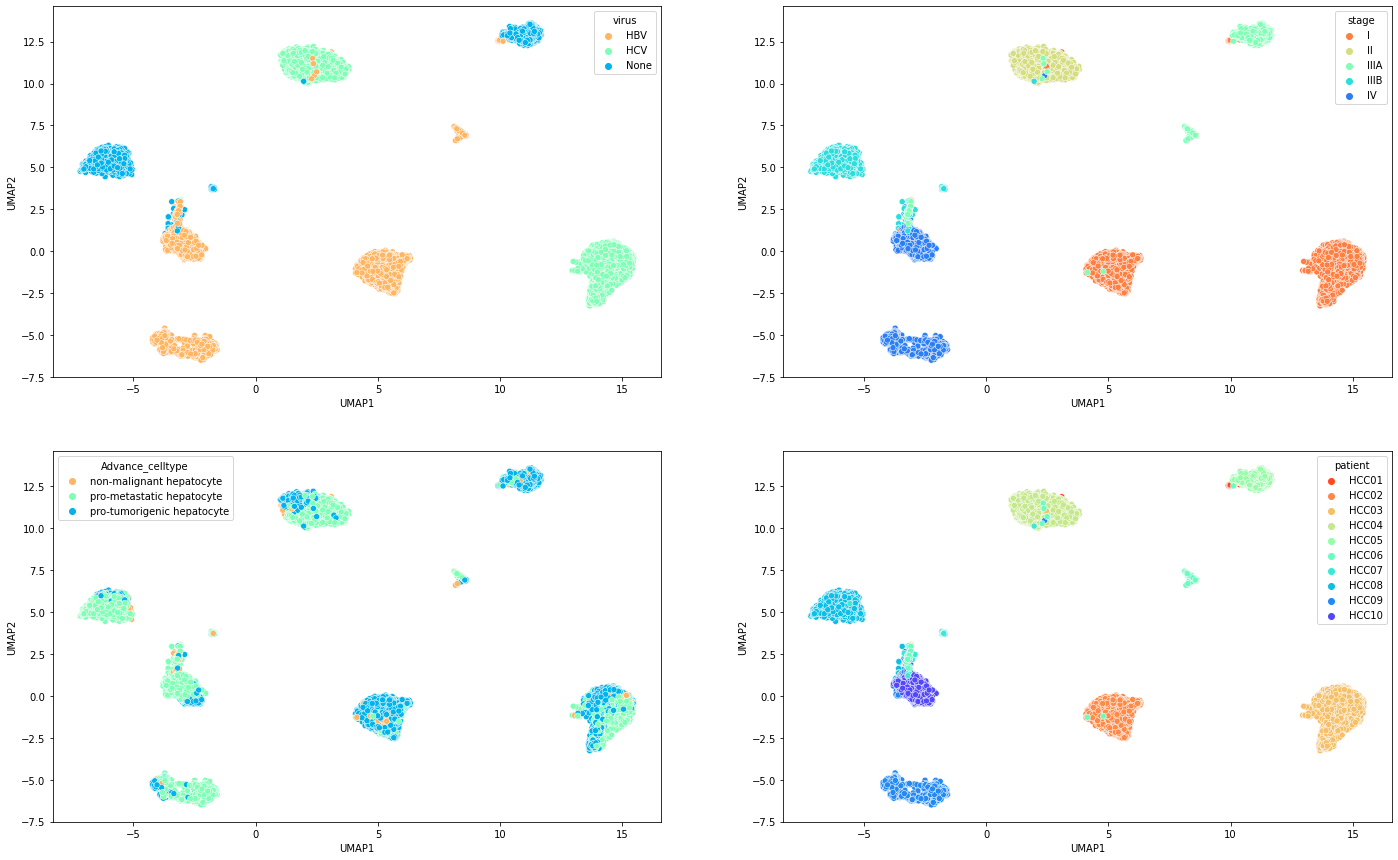

In [16]:
#embedding_df = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/scRNA_seurat/seurat_hvgs_umap_embedding.txt",sep='\t',index_col=0)
fig,axs = plt.subplots(2,2,figsize=(24,15))
conditions = ['virus','stage','Advance_celltype','patient']
for idx,ax in enumerate(axs.ravel()):
    condition = conditions[idx]
    sns.scatterplot(data=embedding_df,x='UMAP1',y='UMAP2',hue=condition,palette='rainbow_r',
                    hue_order = sorted(set(embedding_df[condition].unique())),ax=ax)
#plt.savefig("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/scRNA_seurat/voted_gene_without_cholangiocyte_umap_scatterplot.png",dpi=300)
plt.show()

### calculate Seurat clustering result

In [5]:
from sklearn.metrics import normalized_mutual_info_score,adjusted_rand_score,silhouette_score
from sklearn.cluster import KMeans

def metadata_coverter(metadata) :
    converter = {}
    for idx,component in enumerate(sorted(metadata.unique())) :
        converter[component] = idx
    return converter

In [32]:
embedding_df = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/scRNA_seurat/seurat_hvgs_umap_embedding.txt",sep='\t',index_col=0)

In [33]:
conditions = ['stage','virus','patient','Advance_celltype']
metric_df = pd.DataFrame(np.zeros([4,3]),index=conditions,columns=['ARI','NMI','SC'])
for condition in  conditions :
    converter = metadata_coverter(embedding_df[condition])
    ground_truth = embedding_df[condition].replace(converter)

    n_cluster = max(ground_truth) + 1
    embedding = embedding_df.iloc[:,0:2].to_numpy()
    kmeans_result = KMeans(n_clusters=n_cluster).fit_predict(embedding) # type: ignore
    metric_dict = {}
    metric_df.loc[condition,'ARI'] = adjusted_rand_score(ground_truth,kmeans_result)
    metric_df.loc[condition,'NMI'] = normalized_mutual_info_score(ground_truth,kmeans_result)
    metric_df.loc[condition,'SC'] = silhouette_score(embedding,labels=kmeans_result) # type: ignore
    print("ARI : %0.3f, NMI : %0.3f , SC : %0.3f" % (metric_df.loc[condition,'ARI'] ,metric_df.loc[condition,'NMI'],metric_df.loc[condition,'SC']) )
metric_df.to_csv("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/scRNA_seurat/seurat_hvgs_umap_clustering_measurement.txt",sep='\t')

ARI : 0.588, NMI : 0.730 , SC : 0.697
ARI : 0.470, NMI : 0.509 , SC : 0.526
ARI : 0.924, NMI : 0.950 , SC : 0.796
ARI : 0.094, NMI : 0.096 , SC : 0.622
